In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [13]:
df = pd.read_csv('/Users/archismanchakraborti/Desktop/python_files/FeynnLabsInternship/Project3/archive/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


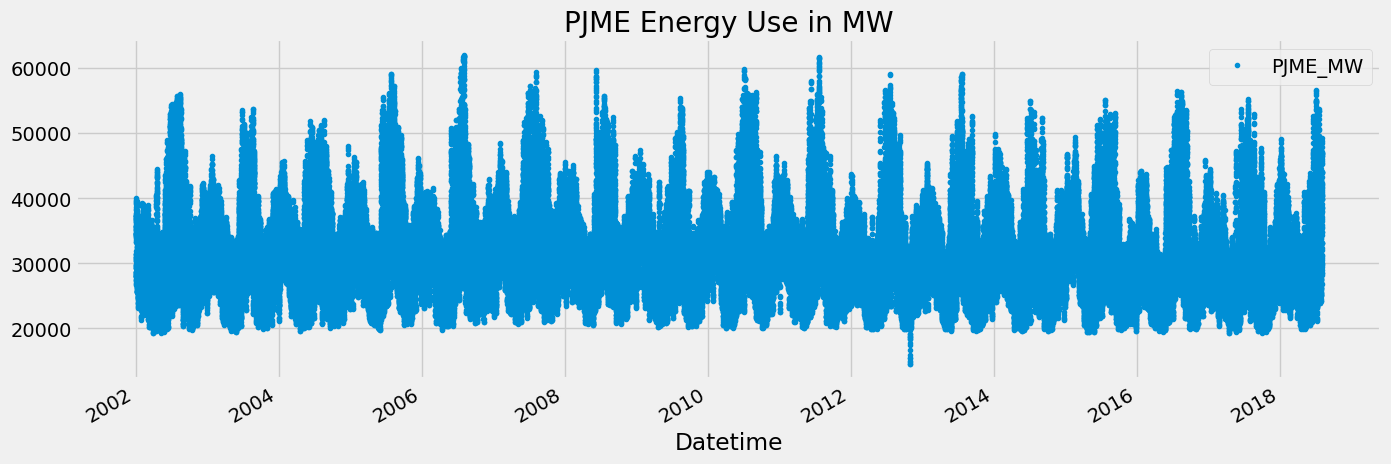

In [14]:
df.plot(style='.',
       figsize=(15, 5),
       color=color_pal[0],
       title='PJME Energy Use in MW')
plt.show()

Train / Test Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
y = df["PJME_MW"]
X = df.index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

train_df = pd.DataFrame(index=X_train, data={'PJME_MW': y_train})
test_df = pd.DataFrame(index=X_test, data={'PJME_MW': y_test})

In [17]:
train, test = train_test_split(df, test_size=0.3, shuffle=False)
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2013-05-23 16:00:00,38525.0
2013-05-23 17:00:00,38544.0
2013-05-23 18:00:00,38057.0


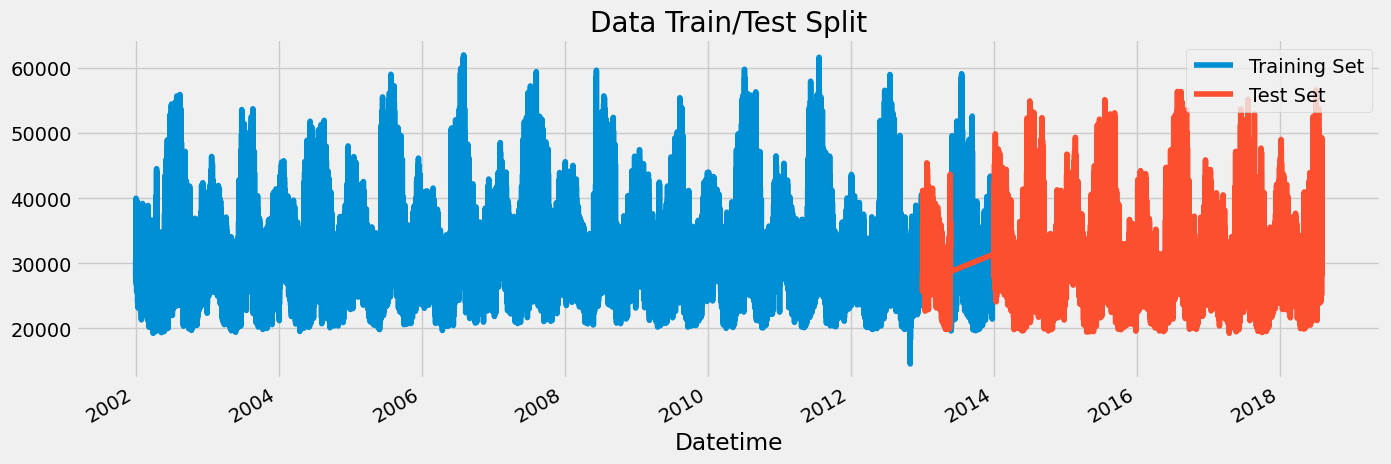

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_df.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

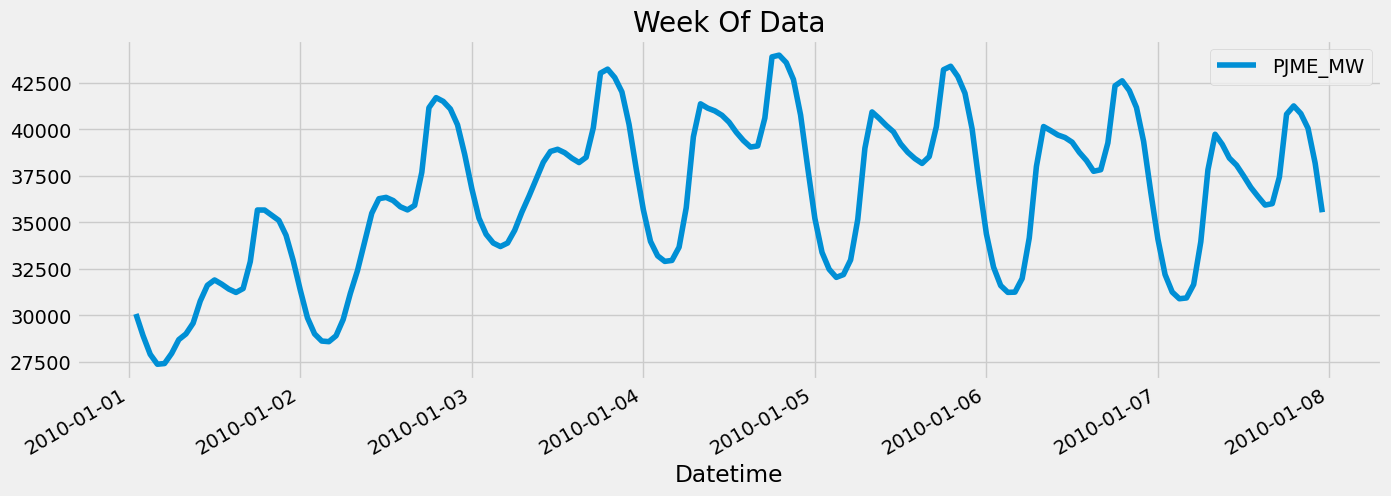

In [19]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
.plot(figsize=(15, 5), title='Week Of Data')
plt.show()

**Feature Creation**

In [20]:
def create_features(df):
    """ 
    Create time series features based on time series index.
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

**Visualize our Feature / Target Relationship**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


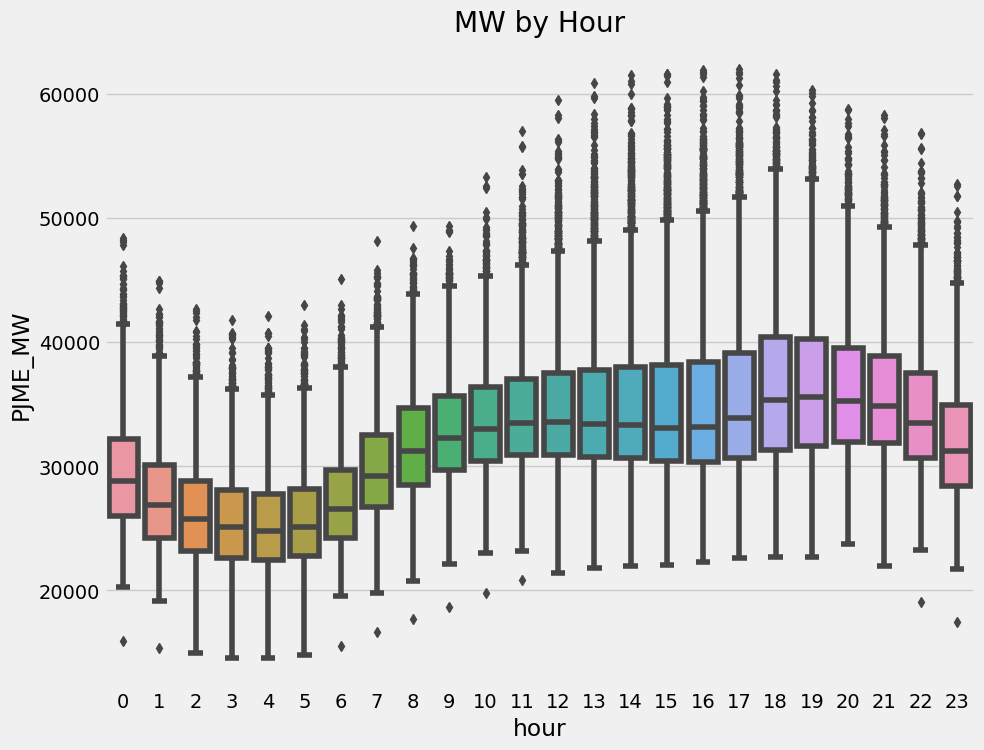

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


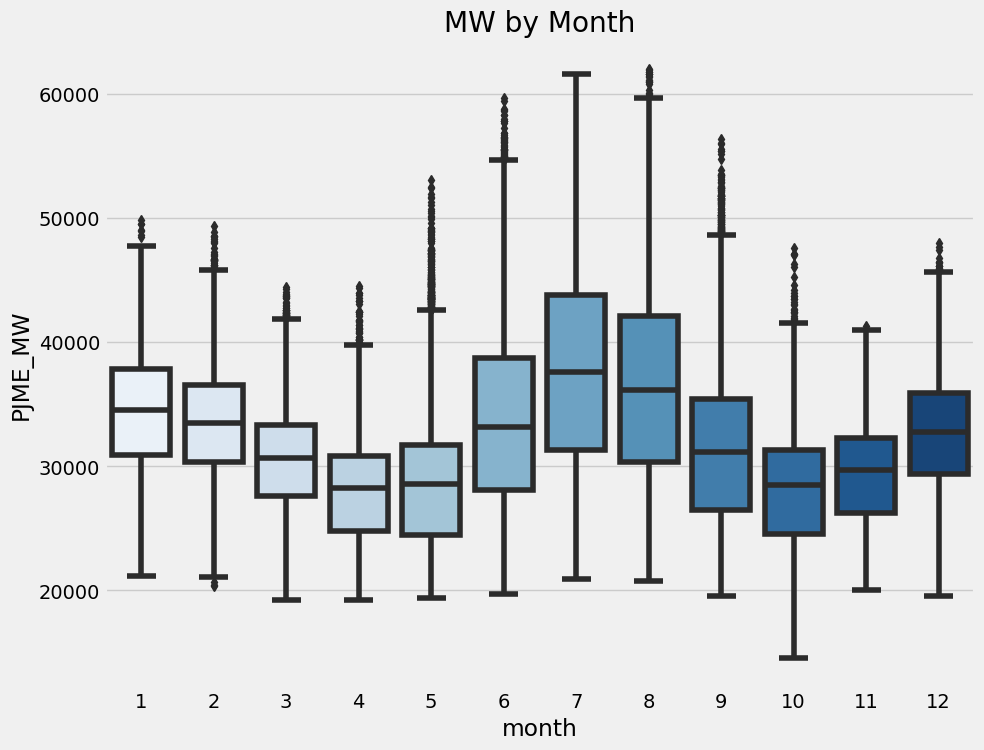

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

**Create our Model**


In [23]:
train = create_features(train_df)
test = create_features(test_df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
df.dtypes.index

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'weekofmonth', 'weekofyear'],
      dtype='object')

In [25]:
reg =xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
                     early_stopping_rounds=50,
                     objective='reg:linear',
                     max_depth=3, 
                     learning_rate=0.01)
reg.fit(x_train, y_train, 
       eval_set= [(x_train, y_train), (x_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32733.48164	validation_1-rmse:31611.77619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

[100]	validation_0-rmse:12624.48459	validation_1-rmse:11644.83487
[200]	validation_0-rmse:5841.69292	validation_1-rmse:5224.49850
[300]	validation_0-rmse:3925.78380	validation_1-rmse:3867.93470
[400]	validation_0-rmse:3451.46998	validation_1-rmse:3723.31075
[500]	validation_0-rmse:3294.07124	validation_1-rmse:3686.69999
[600]	validation_0-rmse:3212.57355	validation_1-rmse:3660.40698
[700]	validation_0-rmse:3160.54831	validation_1-rmse:3646.52750
[800]	validation_0-rmse:3118.43679	validation_1-rmse:3639.39364
[900]	validation_0-rmse:3083.40967	validation_1-rmse:3634.32982
[999]	validation_0-rmse:3054.01223	validation_1-rmse:3632.46896


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

**Feature Importance**

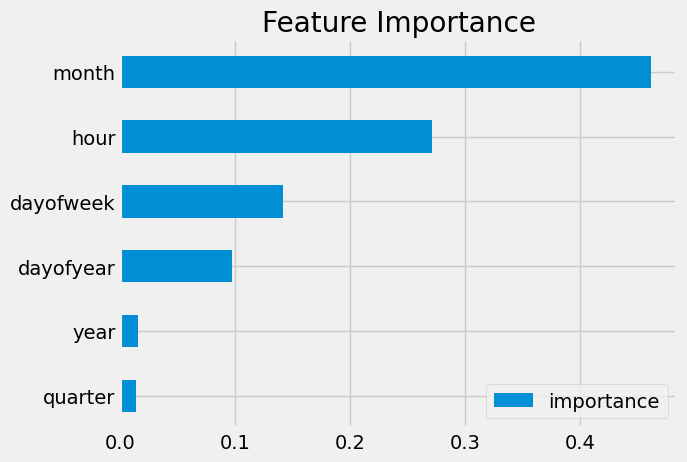

In [26]:
fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [27]:
fi.sort_values('importance', ascending=False).index[:4]

Index(['month', 'hour', 'dayofweek', 'dayofyear'], dtype='object')

**Forecast on Test**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

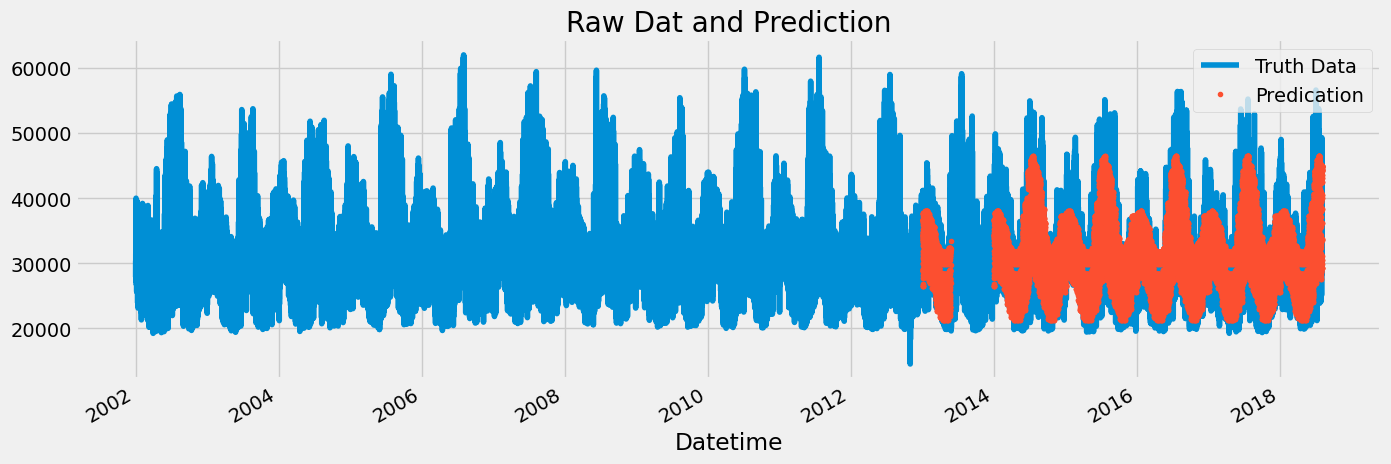

In [28]:
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how= 'left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predication'])
ax.set_title('Raw Dat and Prediction')
plt.show()

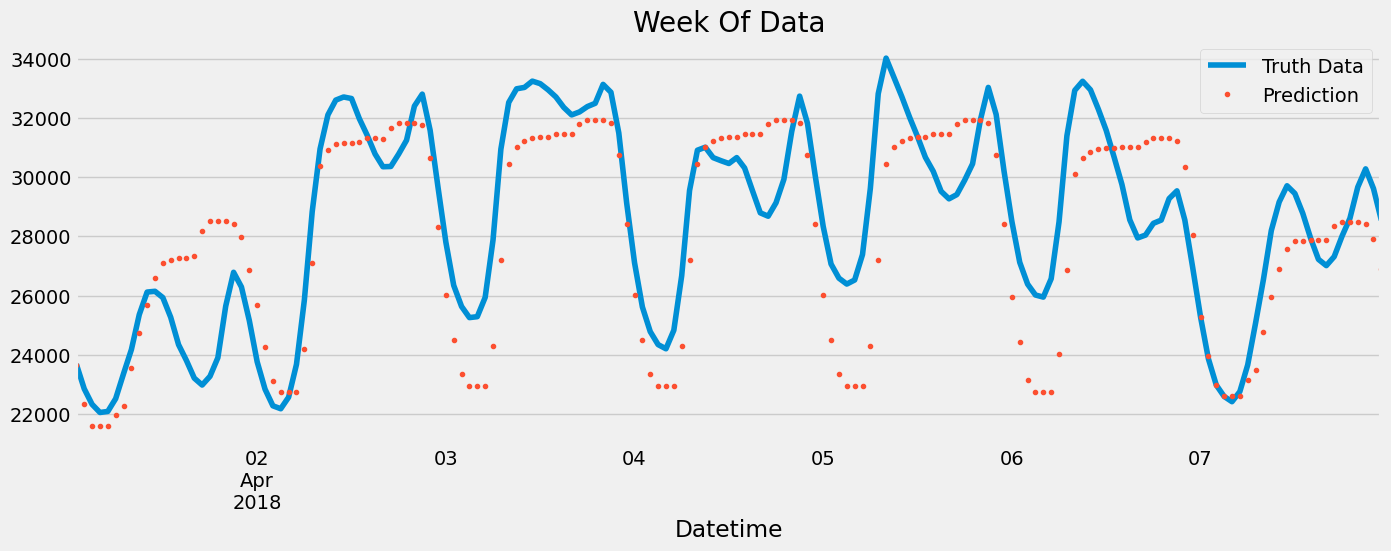

In [29]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Score (RMSE)


In [30]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3632.06


Calculate Error
 Look at the worst and best predicted days

In [31]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-20    12265.299642
2016-09-10    11555.689616
2016-08-14    11423.894124
2016-08-13    11288.684733
2018-01-06    11274.323324
2015-02-16    10781.708577
2015-02-21    10749.508545
2016-09-09    10723.391683
2018-01-07    10424.773519
2015-02-15    10387.298828
Name: error, dtype: float64

In [32]:
df = pd.read_csv("/Users/archismanchakraborti/Desktop/python_files/FeynnLabsInternship/Project3/archive/PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
